# Homologia
## Continuacion del codigo en:
## Filtración de Vietoris-Rips

Como conjunto de datos, se usan palabras. La lista de palabras es:


Se hace una filtracion de vietoris-rips en los datos

In [1]:
import numpy as np
from itertools import chain, combinations
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

### Definir el conjunto de datos

In [2]:
# lista de palabras con el mismo numero de letras
datos = ["hola", "gato", "pato", "cola", "coma", "malo", "mano", "toga", "cosa", "casa", "pasa"]

#datos = ["gato", "pato", "cola", "casa", "pasa"]

# ver cuantas palarbas hay
num_datos = len(datos)
print(f"Hay {num_datos} palabras")

# ver que todas tengan el mismo numero de letras
tamaños = [len(word) for word in datos]
assert len(set(tamaños)) == 1 # todas del mismo tamaño

# ver cual es el tamaño comun
num_letras = tamaños[0]
print(f"Todas las palabras tienen {num_letras} letras")

Hay 11 palabras
Todas las palabras tienen 4 letras


### Definir la metrica

Se usa la distancia de Hamming

In [3]:
# distancia entre dos palabras
def d(w1, w2):
    # la distancia empieza en 0
    distancia  = 0
    
    # por cada disimilitud en letras, aumentar en uno
    for idx in range(num_letras):
        if w1[idx] != w2[idx]:
            distancia += 1
    
    # devolver distancia
    return distancia

### Hacer la matriz de distancias

Bonus

In [4]:
def hacer_matriz_distancias(datos, metrica):
    ''' 
    Argumentos
    datos: conjunto de datos
    metrica: funcion de distancia
    
    Se construye la matriz de distancia asociada a estos datos
    con la metrica dada
    matriz_distanica[i, j] = distancia(dato_i, dato_j)
    
    Se devuelve esta matrz
    '''
    
    # ver cuantos datos hay
    numero_datos = len(datos)
    
    # inicializar la matriz en ceros
    matriz_distanicas = np.zeros((numero_datos, numero_datos))

    # iterar en las filas
    for i in range(numero_datos):
        # iterar en las columans:
        for j in range(numero_datos):
            # poner la diferencia en esa entrada
            matriz_distanicas[i, j] = metrica(datos[i], datos[j])
            
    # devolverla
    return matriz_distanicas

### Funciones auxiliares

Para posteriormente hace la filtración de Vietoris-Rips

Funcion que obtiene todos los subconjuntos no vacios de una lista

In [5]:
def obtener_subconjuntos_no_vacios(lista):
    
    # convierte la lista en un iterable
    lista_iterable = iter(lista)
    
    # genera todos los subconjuntos posibles, que no sean vacios
    subconjuntos = chain.from_iterable(combinations(lista, size) for size in range(1, len(lista) + 1))
    
    # hacer que los elementos sean listas, y que todo sea una lista
    subconjuntos = list([list(elemento) for elemento in subconjuntos])
    
    return subconjuntos

In [6]:
def indices_de_simplejo(indices, matriz_dist, epsilon):
    '''
    Argumentos:
    indices: lista de indices de elementos de los datos
    matriz_dist: matriz de distancia de los datos
    epsilon: argumento para la consieracion del complejo VR
    
    Devuelve True si los indices son de un simplejo
    o Falso si no lo son
    '''
    
    # una lista de indices define un simplejo
    # si la distancia entre todos los pares es menor a epsilon
    
    # considerar que al principio
    # se asumeq que son indices de simplejos
    valido = True
    
    
    # iterar en todos los pares
    for par in combinations(indices, 2):
        
        # si la distancia entre este par es mayor a espilon
        # entonces los indices no son de un simplejo
        if matriz_dist[par[0], par[1]] > epsilon:
            # no son indices de un simplejo
            valido = False
    
    return valido

## Extra de Homologia: Calcular los numeros de betty del complejo simplicial

In [7]:
# dimension de un simplejo
def dimension(simplejo):
    return len(simplejo) - 1

In [8]:
# i-esqueleto de un complejo simplicial
def i_esqueleto(i, complejo_simplicial):
    return np.array([simplejo for simplejo in complejo_simplicial if dimension(simplejo) == i])

In [9]:
# funcion que devuelve todas las caras de un simplejo k-dimensional
# tal que sean k-1 dimensional
def get_caras_simplejo(simplejo):
    
    # poner las caras de una dimension menos
    caras = []
    
    # quitar los vertices de uno en uno
    # iterar en todas las posiciones
    for i in range(0, len(simplejo)):
        
        # quitar el vertice en esa posicion
        cara_i = simplejo[:i] + simplejo[i+1:]
        
        # agregarla
        caras.append(cara_i)

    return caras

In [10]:
# funcion que da la matria asociada al operador frontera
# se le da la base del dominio y el codomino
# base_dominio es el esqueleto_i
# base_codominio es el esqueleto_(i-1)

def get_matriz_frontera(base_dominio, base_codominio):
    
    # tomar las dimensiones
    n = len(base_dominio)
    m = len(base_codominio)
    
    base_dominio = [list(simplejo) for simplejo in base_dominio]
    base_codominio = [list(simplejo) for simplejo in base_codominio]
    
    # como el operador va
    # C_i -> C_(i-1)
    # la matriz tiene dimension mxn
    
    matriz = np.zeros((m, n))
    
    # llenar la matriz, columna por columna
    # segun la frontera de cada elemento de la base del dominio
    
    for indice_simplejo, simplejo in enumerate(base_dominio):
        
        # calcular las caras de este simplejo
        caras_simplejo = get_caras_simplejo(list(simplejo))
        
        # iterar en las caras
        for idx_cara, cara in enumerate(caras_simplejo):
            
            # calcular el signo asociado
            signo_cara = (-1)**idx_cara
            
            # ver cual es el indice de la cara
            # en el orden dado por la base
            # pues es un elemento de la base del codominio
            indice_cara = base_codominio.index(cara)
            
            # poner la entrada correspondiente
            matriz[indice_cara, indice_simplejo] = 1 * signo_cara
            
            
    return matriz

In [11]:
# calcular el rango de una matriz

def calcular_rango(matriz):
    
    rango = np.linalg.matrix_rank(matriz)
    
    return rango

In [12]:
def rango_frontera_i(i, complejo_simplicial):
    # da el rango del operador frontera i-esimo
    
    # este operador va de C_i -> C_(i-1)
    
    # tomar las bases del dominio y codominio
    
    base_dominio = i_esqueleto(i, complejo_simplicial)
    base_codominio = i_esqueleto(i-1, complejo_simplicial)
    
    # si alguna de las dos bases es vacia
    # entonces el rango del operador es 0
    
    if len(base_dominio)==0 or len(base_codominio)==0:
        return 0
    
    # ambas bases son no vacias    
    # hacer la matriz asociada a la frontera
    matriz_frontera = get_matriz_frontera(base_dominio, base_codominio)
    
    # calcular el rango
    rango_i = calcular_rango(matriz_frontera)
    
    return rango_i

In [13]:
# calcula los numeros de betty del complejo simplicial
def get_numeros_betty(complejo_simplicial):
    
    # ver cuales numeros de betty tiene sentido calcular
    # tantos como la dimension del simplejo con mayor dimension
    dimensiones_simplejos = np.array([dimension(simplejo) for simplejo in complejo_simplicial])
    max_numero_betty = max(dimensiones_simplejos)

    print(f"Se calculan {max_numero_betty+1} numeros de betty")
    print(f"Del 0 al {max_numero_betty}")


    # ponerlos vacios primero
    numeros_betty = [-1] * (max_numero_betty+1)

    # llenar uno a uno
    # poner el i-esimo numero de betty
    for i in range(0, max_numero_betty+1):

        print("-"*40)
        print(f"Se calcula el numero de betty {i}:")
        print("")

        # b_i(K) = |K_i| - (r_i + r_(i+1))

        # tomar el esqueleto y la cardinalidad
        esqueleto = i_esqueleto(i, complejo_simplicial)
        card_esqueleto = len(esqueleto) # esto es |K_i|
        print(f"El {i}-esqueleto tiene {card_esqueleto} elementos")


        print(f"Se calcula el rango de los operadores frontera {i} y {i+1}")
        # esto es r_i y r_(i+1)

        r_i = rango_frontera_i(i, complejo_simplicial)
        r_i_mas_1 = rango_frontera_i(i+1, complejo_simplicial)

        print(f"Rango del operador frontera {i}: {r_i}")
        print(f"Rango del operador frontera {i+1}: {r_i_mas_1}")

        # b_i(K) = |K_i| - (r_i + r_(i+1))
        bety_i = card_esqueleto - (r_i + r_i_mas_1)
        # agregar a la lista
        numeros_betty[i] = bety_i

        print(" ")
        print(f"El numero de betty {i} es: {bety_i}")


    # imprimir todos juntos
    print("-"*40)
    print("Resumen, numeros de betty:")
    for idx, b in enumerate(numeros_betty):
        print(f"B_{idx}: {b}")
    
    return numeros_betty

### Filtración de Vietoris-Rips. Ahora con homologia

In [14]:
def VR(datos, metrica, epsilon):
    ''' 
    Argumentos
    datos: conjunto de datos
    metrica: funcion de distancia entre los datos
    Estos dos argumentos definen un espacio metrico finito (datos)
    epsilon: argumento para la construccion del complejo
    
    Se construye el complejo de Vietoris-Rips asociado a estos datos,
    con el epsilon dado. Usa fuerza bruta
    
    Tambien se calculan los numeros de betty del complejo simplicial creado
    
    Se devuelve el complejo simplicial abstracto
    '''
    
    print("Los datos son:")
    print(datos)
    print(" ")
    
    # hacer los indices de los datos, para manejo mas facil
    indices_datos = list(range(len(datos)))
    
    # ver todos los subconjuntos posibles de estos indices, no vacios 
    # esto es, los indices de los posibles simplejos
    subconjuntos_indices = obtener_subconjuntos_no_vacios(indices_datos)
    
    # asegurar que se tengan los que se esperan
    assert len(subconjuntos_indices) == 2**(len(datos)) - 1
    
    # se tiene la metrica y los datos
    # obtener la matriz de distancias de los datos
    matriz_dist = hacer_matriz_distancias(datos, metrica)
    
    # ir guardando todos los simplejos del complejo simplicial
    # en una lista, comienza vacia
    complejo_simplicial = []
    
    # iterar en todos los posibles simplejos
    # mas bien, en los indices de todos los posibles simplejos
    for indices in subconjuntos_indices:
        
        # checar si estos indices representan un simplejo
        if indices_de_simplejo(indices, matriz_dist, epsilon):
            
            # obtener el simplejo, solo se tienen los indices
            simplejo = [datos[i] for i in indices]
            
            # añadrirlo al complejo simplicial, como conjunto
            complejo_simplicial.append(set(simplejo))    
        
    ####################################################
    ####################################################
    # Dibujar??

    # reducir las dimensiones a 2, para graficar
    pca = PCA(n_components=2)
    
    # se toman como vectorizaciones las distancias entre puntos
    # se pasan a dos dimensiones para graficar
    coordenadas = pca.fit_transform(matriz_dist)
    
    # tomar coordenadas x,y de los datos
    x = [coord_x_y[0] for coord_x_y in coordenadas]
    y = [coord_x_y[1] for coord_x_y in coordenadas]
    
    
    # hacer la grafica
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # poner los puntos
    plt.scatter(x, y, c = 'red')
    
    # poner la etiqueta de la palabra en cada punto
    for i, palabra in enumerate(datos):
        plt.annotate(palabra, (x[i], y[i]), textcoords="offset points", xytext=(-15, 15), ha='center')
        
        
    # graficar cada simplejo
    # iterar en ellos
    for simplejo in complejo_simplicial:
        
        # obtener los indices de las palabras del simlpejo
        indices_simplejo = [datos.index(palabra) for palabra in simplejo]
        # obtener las coordenadas x,y de cada elemento del simplejo
        coordenadas_simplejo = np.array([list(coordenadas[i]) for i in indices_simplejo])
        
        # obtener la longuitud del simplejo
        len_simplejo = len(simplejo)
        
        
        # los colores de los simplejos cambian de acuerdo 
        # al numero de vertices
        colores_simplejos = {1: 'red', 2: 'black', 3: 'green', 4:'blue', 5:'purple', 6:'orange', 7:'yellow'}

        
        # SIMPLEJOS DE DIMENSION 0 (1 ELEMENTO)
        # Estos son solo puntos, y estos ya se pusieron
        # no se hace nada
        if len_simplejo == 1:
            continue
            
        # SIMPLEJOS DE DIMENSION 1 (2 ELEMENTOS)
        # Estos solo son lineas entre puntos
        if len_simplejo == 2:
            plt.plot(coordenadas_simplejo[:, 0], coordenadas_simplejo[:, 1], 'k-')
            continue
            
            
        # SIMPLEJOS CON DIMENSION AL MENOS 2 (AL MENOS 3 ELEMENTOS)
        # ver si se puede asignar un color al simplejo
        # de acuerdo a su longuitud (aca len_simplejo>=3)
        if len_simplejo in colores_simplejos.keys():
            color = colores_simplejos[len_simplejo]
        # si no se puede asignar un color, se usa gris
        # es decir, si tiene longuitud mayor a 8
        else:
            color = 'gray'
    
        # Rellenar el simplejo con su color correspondiente
        
        # primero se calcula la envolvente convexa
        hull = ConvexHull(coordenadas_simplejo)
        # esta da el orden de los vertices que se va a considerar
        # para dibujar el simplejo
        vertices_ordenados = coordenadas_simplejo[hull.vertices]

        # rellenar el simplejo
        ax.fill(vertices_ordenados[:, 0], vertices_ordenados[:, 1], color, alpha = 0.6)
    
    
    # poner leyenda
    # obtener la longuitud del simplejo mayor
    longuitudes_simplejos = [len(simplejo) for simplejo in complejo_simplicial]
    len_simplejo_max = np.array(longuitudes_simplejos).max()
    
    # ir poniendo hasta el mayor, se pone la leyenda en cada uno
    for i in range(1, min(len_simplejo_max+1, 8)):
        label = f"Simplejos de dimension {i-1}"
        ax.plot([], [], 'o', color=colores_simplejos[i], markersize=5, label=label)
    # si es mayor a 7, es que hay uno gris, un simplejo con mas de 7 elementos
    if len_simplejo_max > 7:
        ax.plot([], [], 'o', color='gray', markersize=5, label=f"Simplejos de dimension mayor a 6")
    # poner la legenda
    ax.legend()
    
    
    # detalles de la grafica y guardar
    name  = f"Filtracion VR, epsilon = {epsilon}"
    plt.title(name)
    plt.axis('off')
    plt.savefig(name + '.png',  bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    ####################################################
    ####################################################
    
    # ver unas cosas del complejos simplicial
    
    print("La matriz de distancias es:")
    print(matriz_dist)
    print(" ")
    
    print(f"Se usa epsilon = {epsilon}")
    print(" ")
    
    
    # darle orientacion al complejo simplicial
    # con orden alfabetico
    complejo_simplicial = [sorted(list(simplejo)) for simplejo in complejo_simplicial]
    
    
    print("Simplejos del complejo de Vietoris-Rips:")
    for simplejo in complejo_simplicial:
        print(simplejo)
        
    #----------------------------------------------------------------------------
    
    # calcular los numeros de betty
    print("-"*30)
    print("Numeros de betty del complejo simplicial")
    print(" ")
    
    numeros_b = get_numeros_betty(complejo_simplicial)

Los datos son:
['hola', 'gato', 'pato', 'cola', 'coma', 'malo', 'mano', 'toga', 'cosa', 'casa', 'pasa']
 


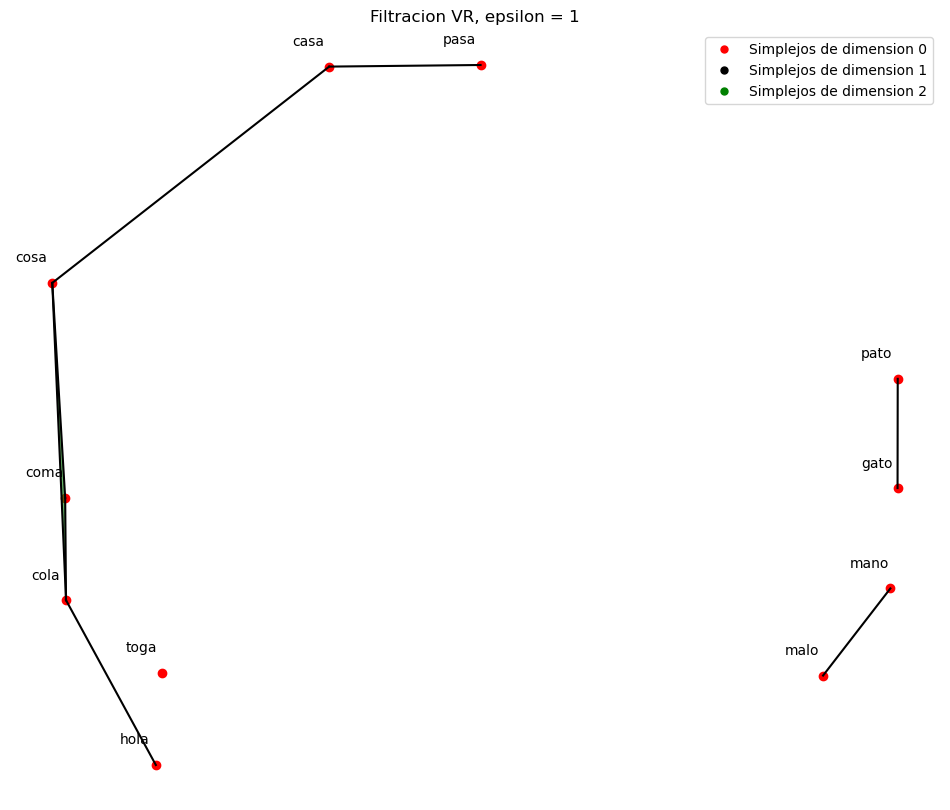

La matriz de distancias es:
[[0. 4. 4. 1. 2. 3. 4. 2. 2. 3. 3.]
 [4. 0. 1. 4. 4. 2. 2. 4. 4. 3. 3.]
 [4. 1. 0. 4. 4. 2. 2. 4. 4. 3. 2.]
 [1. 4. 4. 0. 1. 3. 4. 2. 1. 2. 3.]
 [2. 4. 4. 1. 0. 4. 4. 2. 1. 2. 3.]
 [3. 2. 2. 3. 4. 0. 1. 4. 4. 3. 3.]
 [4. 2. 2. 4. 4. 1. 0. 4. 4. 3. 3.]
 [2. 4. 4. 2. 2. 4. 4. 0. 2. 3. 3.]
 [2. 4. 4. 1. 1. 4. 4. 2. 0. 1. 2.]
 [3. 3. 3. 2. 2. 3. 3. 3. 1. 0. 1.]
 [3. 3. 2. 3. 3. 3. 3. 3. 2. 1. 0.]]
 
Se usa epsilon = 1
 
Simplejos del complejo de Vietoris-Rips:
['hola']
['gato']
['pato']
['cola']
['coma']
['malo']
['mano']
['toga']
['cosa']
['casa']
['pasa']
['cola', 'hola']
['gato', 'pato']
['cola', 'coma']
['cola', 'cosa']
['coma', 'cosa']
['malo', 'mano']
['casa', 'cosa']
['casa', 'pasa']
['cola', 'coma', 'cosa']
------------------------------
Numeros de betty del complejo simplicial
 
Se calculan 3 numeros de betty
Del 0 al 2
----------------------------------------
Se calcula el numero de betty 0:

El 0-esqueleto tiene 11 elementos
Se calcula el rango de los

In [15]:
# hacer el complejo de Vietoris-Rips de los datos
VR(datos, d, 1)

In [16]:
# probar calcular los numeros de betty en otro complejo simplicial
# en el 3 simplejo-hueco
complejo_simplicial = [['v0'], ['v1'], ['v2'], ['v3'],
                      ['v0', 'v1'], ['v0', 'v2'], ['v0', 'v3'],
                      ['v1', 'v2'], ['v1', 'v3'], ['v2', 'v3'],
                      ['v1', 'v2', 'v3'], ['v0', 'v2', 'v3'],
                      ['v0', 'v1', 'v3'], ['v0', 'v1', 'v2']]
get_numeros_betty(complejo_simplicial)

Se calculan 3 numeros de betty
Del 0 al 2
----------------------------------------
Se calcula el numero de betty 0:

El 0-esqueleto tiene 4 elementos
Se calcula el rango de los operadores frontera 0 y 1
Rango del operador frontera 0: 0
Rango del operador frontera 1: 3
 
El numero de betty 0 es: 1
----------------------------------------
Se calcula el numero de betty 1:

El 1-esqueleto tiene 6 elementos
Se calcula el rango de los operadores frontera 1 y 2
Rango del operador frontera 1: 3
Rango del operador frontera 2: 3
 
El numero de betty 1 es: 0
----------------------------------------
Se calcula el numero de betty 2:

El 2-esqueleto tiene 4 elementos
Se calcula el rango de los operadores frontera 2 y 3
Rango del operador frontera 2: 3
Rango del operador frontera 3: 0
 
El numero de betty 2 es: 1
----------------------------------------
Resumen, numeros de betty:
B_0: 1
B_1: 0
B_2: 1


[1, 0, 1]